# Many Labs 1 re-analysis
Re-analysis of data from https://osf.io/wx7ck/. <br>


# Index
[1. Preprocessing](#preprocessing) <br>
[2. Recompute effect sizes from Klein et al., 2014](#recompute) <br>
[3. "Standard" regression](#regression) <br>
[4. Regression with a bunch of random predictors](#random) <br>
[5. Cross-validated regression](#cv) <br>
[6. Predict condition based on DV](#reverse) <br>
[7. Cross-validated regression with random predictors](#random_cv) <br>
[8. Summary tables](#summary) <br>
[9. Plot performance](#plot) <br>
[10. Sample size, performance and overfitting](#samplesize) <br>
[11. Effect variability across sites](#sites)


Notebook includes: <br>
1) recomputing effect sizes from the paper <br>
2) running "standard" regular regression analysis for all effects (extract coefficients, R-squared/classification accuracy and p-vals) <br>
3) comparing with cross-validated regression <br>
4) running cross-validated regression with some random predictors (e.g. age, us vs. international sample, etc.) <br>
5) try to classify condition based on dependent variable (again using CV)

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
import math
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GroupKFold, KFold, cross_validate
from IPython.display import Image

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## 1. Preprocessing <a class="anchor" id="preprocessing"></a>

### Read in the dataset 

In [3]:
df = pd.read_csv('manylabs1_data/processed_data.txt', sep='\t')

### Define useful functions

1)  Define function to compute Cohen's d and standardized mean difference

In [4]:
def compute_metrics(out_name, group_name, levels):
    ''' Returns cohen\'s d and standardized mean difference for anchoring studies'''
    # Subset relevant data 
    cond_1 = df[out_name][df[group_name] == levels[0]]
    cond_2 = df[out_name][df[group_name] == levels[1]]
    # Compute metrics 
    m1 = cond_1.mean()
    m2 = cond_2.mean()
    stdev = df[out_name].std()
    n1 = cond_1.notnull().sum()
    n2 = cond_2.notnull().sum()
    # Cohen's d
    pool_std1 = (n1 - 1) * cond_1.std()**2
    pool_std2 = (n2 - 1) * cond_2.std()**2
    d = (m2 - m1) / math.sqrt((pool_std1 + pool_std2)/(n1 + n2 - 2))
    # Standardized difference
    stdmdiff = m1 - m2 / stdev
    return d, stdmdiff

2) Define function to split data into X and y based on IV and DV column names

In [5]:
def split_data(group_col, dv_col):
    X = df_stats[group_col][df_stats[dv_col].isnull() == False].dropna().values.reshape(-1,1)
    y = df_stats[dv_col][df_stats[group_col].isnull() == False].dropna().values
    grp = df_stats['sample'][(df_stats[group_col].isnull() == False) & (df_stats[dv_col].isnull() == False)]
    return X, y, grp

3) Define function to fit OLS or logistic regression models

In [6]:
def fit_model(group_col, dv_col, type='reg'):
    X, y, grp = split_data(group_col, dv_col)
    X2 = sm.add_constant(X)
    if type =='reg':
        est = sm.OLS(y, X2)
    elif type == 'class':
        est = sm.Logit(y, X2)
    m = est.fit()
    if type == 'reg':
        outs = (np.nan, m.rsquared, m.params[1], m.pvalues[1])
    else:
        acc = np.diag(m.pred_table()).sum() / m.pred_table().sum()
        outs = (acc, np.nan, m.params[1], m.pvalues[1])
    return outs

Recode categorical variables (DVs to 0/1 coding + simplify coding of some conditions)

In [7]:
df['allowedforbidden_bin'] = df['allowedforbidden'].map({'YES':1, 'NO':0})
df['gainlossgroup'] = df['gainlossgroup'].map({'People will die':'die', 'People will be saved':'saved'})
df['gainlossDV_bin'] = df['gainlossDV'].map({'chose program with exact outcome':0, 'chose program with probability outcome':1})
df['scalesgroup'] = df['scalesgroup'].map({'high category scale':'high', 'low category scale':'low'})
df['scales_bin'] = df['scales'].map({'less than 2 1/2 hrs':0, 'more than 2 1/2 hrs':1})
df['reciprocityus_bin'] = df['reciprocityus'].map({'yes':1, 'no':0})

For future purposes, make lists specifying the names of the DVs and the condition columns.

In [8]:
dvs = ['anchoring' + str(i) for i in range(1,5)] + ['allowedforbidden_bin', 'gambfalDV', 'gainlossDV_bin','d_art', 'scales_bin', 'quote', 'reciprocityus_bin','sunkDV', 'Imagineddv', 'flagdv', 'Sysjust']
grps = ['anch' + str(i) + 'group' for i in range(1,5)] + ['allowedforbiddenGroup', 'gambfalgroup', 'gainlossgroup', 'sex', 'scalesgroup', 'quoteGroup', 'reciprocitygroup', 'sunkgroup', 'ContactGroup', 'flagGroup', 'MoneyGroup']


Also make list which includes info on levels of each IVs.

In [9]:
levels = [['lowanchor', 'highanchor']] * 4 + [['allowed', 'forbidden'], ['two6', 'three6'], ['die', 'saved'], ['m', 'f'], ['high', 'low'], ['liked source', 'disliked source'], ['Asked first', 'Asked second'], ['paid', 'free'], ['Control group', 'Contact group'], ['no prime', 'flag prime'], ['Control group', 'Money priming group']]

Make list specifying whether each problem is a regression or a classification problem

In [10]:
reg_vs_class = ['reg','reg','reg','reg','class','reg','class','reg','class','reg','class','reg','reg','reg','reg']

Add some lists containing interpretable information on what each DV indicates, as well as more perspicuous naming of the effects. 

In [11]:
dvs_explain = ['SF-NYC distance', 'Pop. Chicago', 'Height Mt. Everest', 'Babies born per day', 'Binary', 'Numer of times dice rolled', 'Binary', 'IAT score', 'Binary', 'Agreement with quote (1-9)', 'Binary', 'Likelihood to attend game (1-9)', 'Aggregate willingness to interact (1-9)', 'Aggregate political conservatism (1-7)', 'Aggregate system justification (1-7)']
effect_names = ['anchoringNY', 'anchoringChicago', 'anchoringMtEverest', 'anchoringBabies', 'allowedforbidden', 'gamblersfallacy', 'gainlossframing', 'mathattitudes', 'low/high scales', 'quoteattribution', 'reciprocity', 'sunkcost', 'imaginedcontact', 'flagpriming', 'currencypriming']

Quick reminder on what each effect is about. All experiments have condition/group as IV, and all are between participant designs.
- **AnchoringNY**: Participants are asked to provide an estimate of the distance between SF and NY, on the basis of some coarse anchor (distance is higher than / lower than X). Conditions differ in magnitude of the anchor (continuous outcome).
- **AnchoringChicago**: Same as above, this time participants estimate the population of Chicago (continuous outcome).
- **AnchoringMtEverest**: Same as above, estimate height of MtEverest (in ft.) (continuous outcome).
- **AnchoringBabies**: Same as above, estimate number of babies born in the US in a day (continuous outcome).
- **AllowedForbidden**: Finds that participants were less likely to endorse forbidding speeches against democracy than they were to not endorse allowing speeches against democracy (binary outcome).
- **Gambler's fallacy**: Participants are asked to provide an estimate of how many times a die has been rolled before the current rolls, where the outcome is either 3 out of 3 times 6, or 2 out of 3 times 6 (numerical/integer outcome).
- **Gain/Loss framing**: Tests participant's willingness to endorse two logically equivalent programs in response to an epidemic as a function of whether the effectiveness is framed in terms of losses (nr deaths) or gains (nr people saved). Binary outcome.
- **Math attitudes**: Compares male and female participants on math attitudes (IAT scores)
- **Low/high scales**: Compares participants' answer to the question whether they watch TV more than 2 1/2 hours a day based on the scale of the options given (binary outcome).
- **Quote attribution**: Tests participants' willingness to endorse the content of a quote based on whether it is attributed to a liked vs. disliked figure (Likert scale)
- **Reciprocity**: Participants are asked whether they would be in favor of letting reporters from a country perceived as an enemy into the US. One of the groups is first asked the reciprocal question, i.e. whether the other country should let US reporters in, while the other group is not asked this question (binary outcome).
- **Sunk cost**: Participants are asked how likely they are to go to a match for which they have either bought a ticket or received one for free in case of bad weather  (Likert scale)
- **Imagined contact**: Tests willingness to interact with foreigner (Muslim in most cases) as a function of whether participants are previously asked to imagine such encounter or imagine something else  (Likert scale)
- **Flag priming**: Tests the extent to which exposure to national flag increases conservative attitudes of participants  (Likert scale)
- **Currency priming**: Tests the extent to which exposure to pictures of banknotes increases participants' willingness to justify/endorse the current social system  (Likert scale).

*NB: we are leaving out the study testing for correlations between implicit and explicit math attitudes*

## 2. Recompute effect sizes from Klein et al., 2014 <a class="anchor" id="recompute"></a>

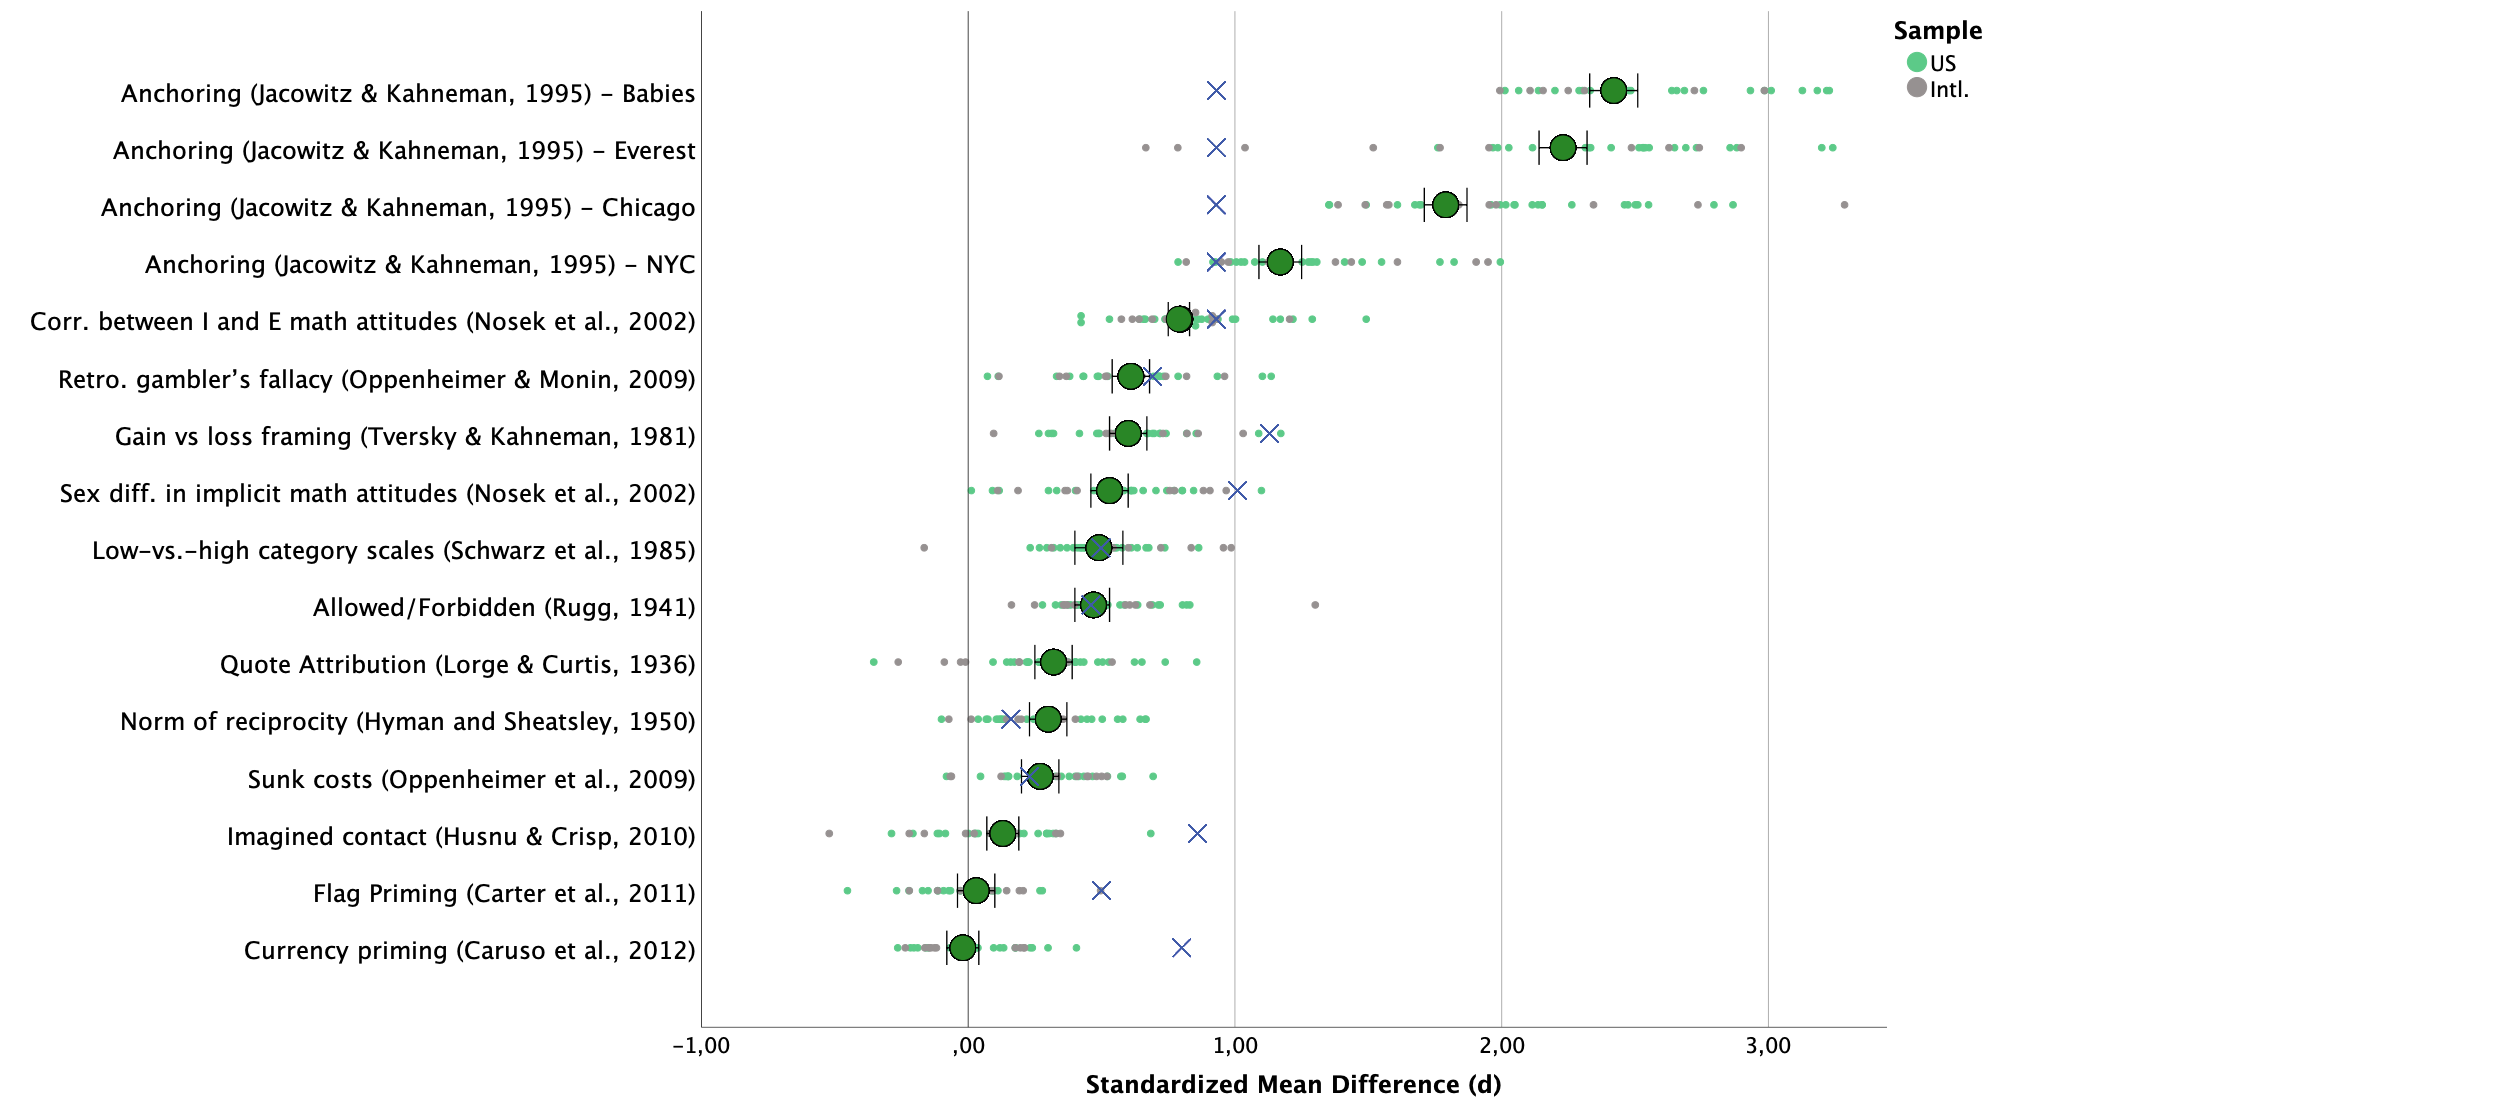

In [12]:
Image('manylabs1_data/figures/Figure1.Colored.png')

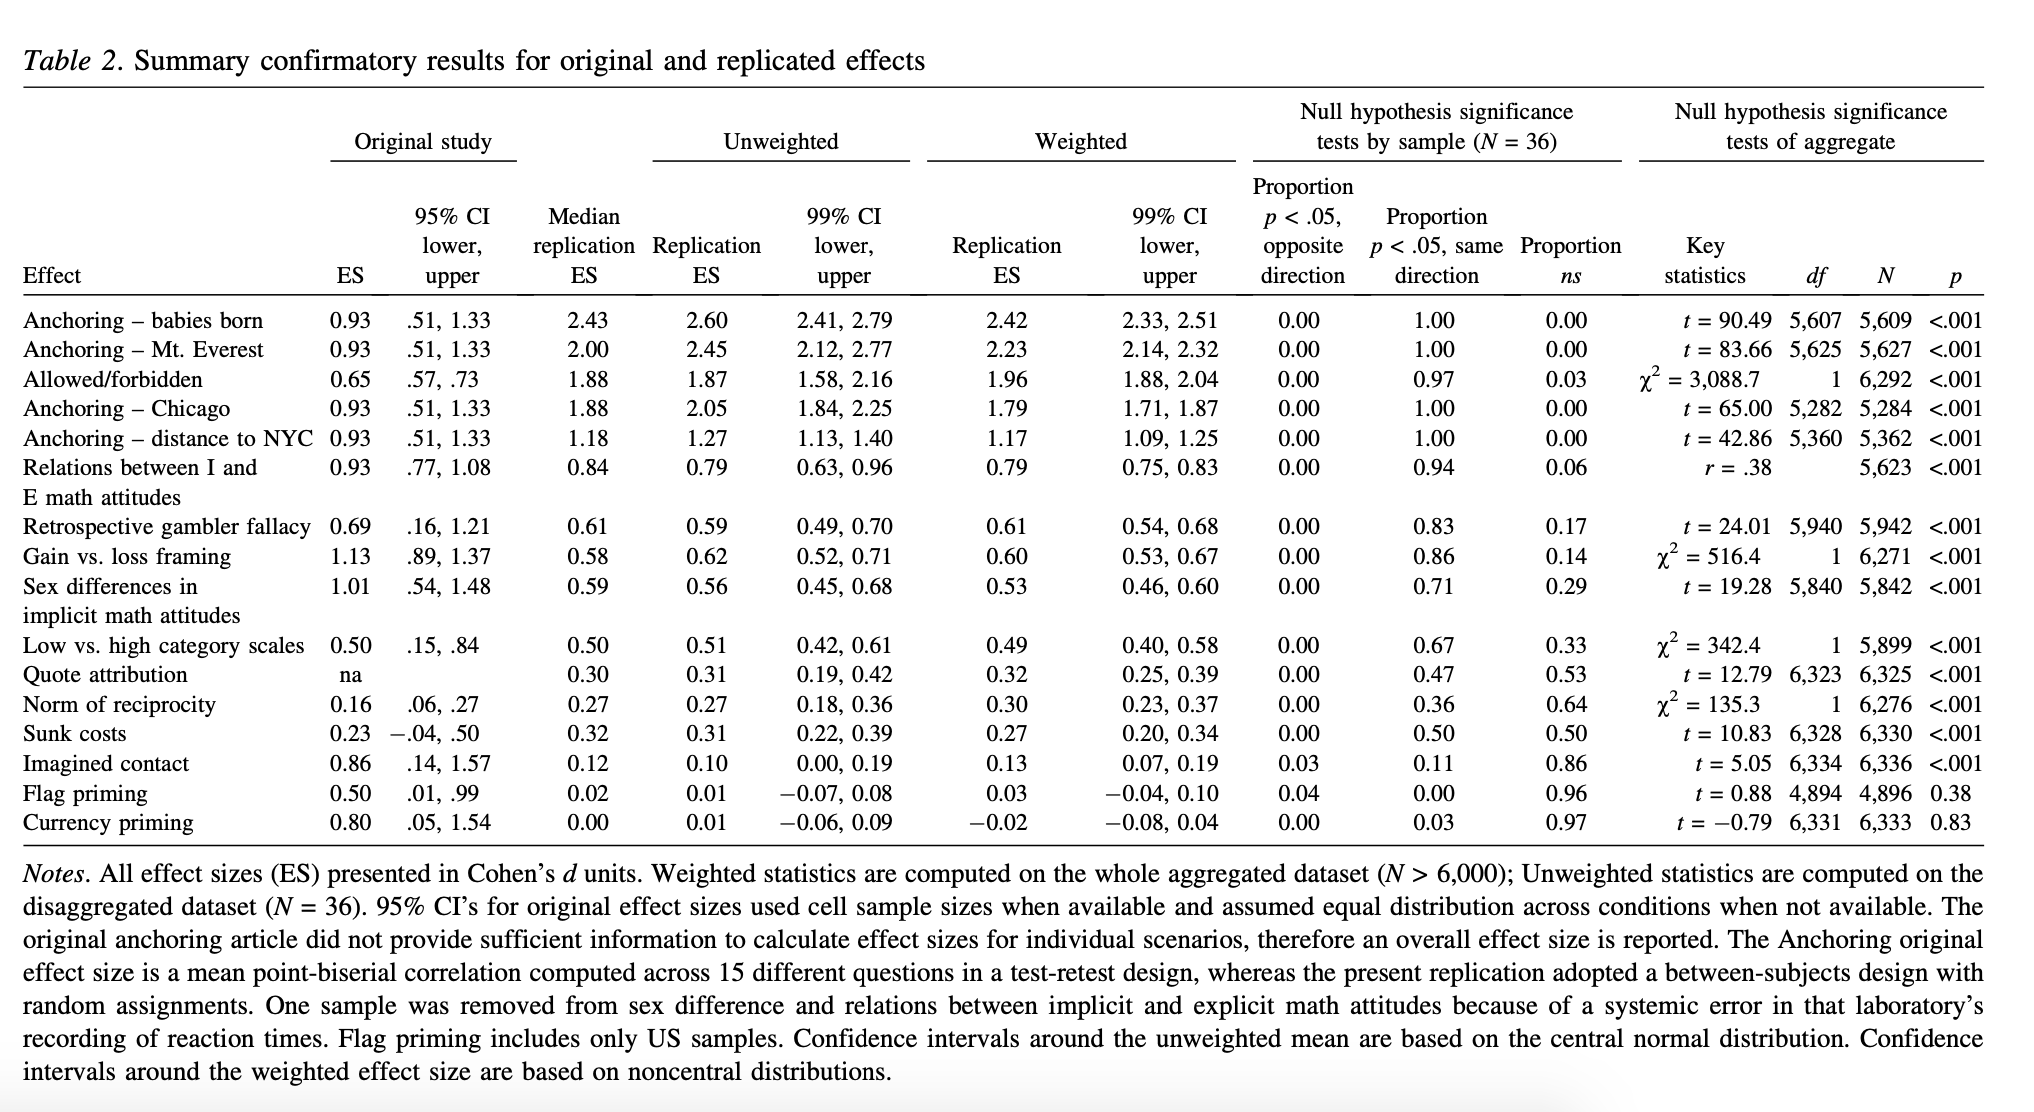

In [13]:
Image('manylabs1_data/figures/Table2.png')

### Compute Cohen's d and standardized mean difference
Note that we are not using rank-transformed DVs for anchoring (so to keep interpretability of MSE values later on), so those values will not be identical.

In [14]:
names, cohensds, stdmeandiffs = [], [], []
for idx in range(len(dvs)):
    names.append(dvs[idx])
    d, smdiff = compute_metrics(dvs[idx], grps[idx], levels[idx])
    cohensds.append(abs(d))
    stdmeandiffs.append(abs(smdiff))

Also compute Pearson's correlation between IV and DV for all studies. <br>
Note that we are creating a copy of the dataset where all DVs are recoded as 0/1.
We will use this for all analyses from now on.

In [15]:
cors = []
df_stats = df.copy()
for idx in range(len(dvs)):
    df_stats[grps[idx]] = df_stats[grps[idx]].map({levels[idx][0]: 0,
                                                   levels[idx][1]: 1})
    cval = df_stats[[dvs[idx], grps[idx]]].corr().iloc[0,1]
    cors.append(cval)

Add info to dataset and take a first look at the dataset

In [16]:
summary = pd.DataFrame(list(zip(effect_names, cohensds, stdmeandiffs, cors, reg_vs_class)), 
                       columns=['effect', 'cohensd', 'std_mean_diff', 'pearsons_r', 'problem_type']) 
display(summary)

,effect,cohensd,std_mean_diff,pearsons_r,problem_type
0,anchoringNY,1.15905,2847.56614,0.50131,reg
1,anchoringChicago,1.77999,1033554.90135,0.66481,reg
2,anchoringMtEverest,2.29785,11846.76164,0.75431,reg
3,anchoringBabies,2.18582,3202.95080,0.73748,reg
4,allowedforbidden,1.96363,0.61604,-0.70064,class
5,gamblersfallacy,0.62590,0.74034,0.29740,reg
6,gainlossframing,0.59908,0.09183,-0.28697,class
7,mathattitudes,0.53339,0.78257,0.24199,reg
8,low/high scales,0.49686,0.04829,-0.24092,class
9,quoteattribution,0.32167,3.53730,-0.15877,reg


## 3. Regression analysis  <a class="anchor" id="regression"></a>
Run OLS or Logistic Regression (DVs ~ condition) for all effects

In [17]:
r2_scores = []
perc_acc = []
coefs = []
pvals = []

# Fit for anchoring effects
for idx in range(len(grps)):
    acc, r2, par, pval = fit_model(grps[idx], dvs[idx], type=reg_vs_class[idx])
    perc_acc.append(acc)
    r2_scores.append(r2)
    coefs.append(par)
    pvals.append(pval)

Optimization terminated successfully.
         Current function value: 0.402598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.401718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595776
         Iterations 5


Add to summary df and display.

In [18]:
summary['reg_coef'] = coefs
summary['reg_perc_acc'] = perc_acc
summary['reg_r2'] = r2_scores
summary['reg_pval'] = pvals
display(summary)

,effect,cohensd,std_mean_diff,pearsons_r,problem_type,reg_coef,reg_perc_acc,reg_r2,reg_pval
0,anchoringNY,1.15905,2847.56614,0.50131,reg,1143.20716,nan,0.25131,0.00000
1,anchoringChicago,1.77999,1033554.90135,0.66481,reg,1964484.41985,nan,0.44198,0.00000
2,anchoringMtEverest,2.29785,11846.76164,0.75431,reg,22652.04180,nan,0.56898,0.00000
3,anchoringBabies,2.18582,3202.95080,0.73748,reg,23497.38255,nan,0.54387,0.00000
4,allowedforbidden,1.96363,0.61604,-0.70064,class,-3.72006,0.84584,nan,0.00000
5,gamblersfallacy,0.62590,0.74034,0.29740,reg,1.69587,nan,0.08845,0.00000
6,gainlossframing,0.59908,0.09183,-0.28697,class,-1.18267,0.64312,nan,0.00000
7,mathattitudes,0.53339,0.78257,0.24199,reg,0.25912,nan,0.05856,0.00000
8,low/high scales,0.49686,0.04829,-0.24092,class,-1.44210,0.84472,nan,0.00000
9,quoteattribution,0.32167,3.53730,-0.15877,reg,-0.69527,nan,0.02521,0.00000


## 4. Regression with a bunch of randomly selected variables <a class="anchor" id="random"></a>
(First recode the variables, then run regression)

In [19]:
df_stats['us_or_international'] = df_stats['us_or_international'].map({'US':0, 'International':1})
df_stats['lab_or_online'] = df_stats['lab_or_online'].map({'In-lab':0, 'Online':1})

Run regression

In [20]:
random_cols = ['age', 'sex', 'us_or_international', 'lab_or_online']
random_r2, random_par, random_pval, random_perc_acc = [], [], [], []
for c in random_cols:
    for idx in range(len(grps)):
        perc_acc, r2, par, pval = fit_model(c, dvs[idx], reg_vs_class[idx])
        random_perc_acc.append(perc_acc)
        random_r2.append(r2)
        random_par.append(par)
        random_pval.append(pval)
random_idx = list(np.repeat(random_cols, len(grps)))

Optimization terminated successfully.
         Current function value: 0.678547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.423837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692039
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.431521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.600329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691825
  

Visualize results (filtered by those where p<.05)

In [21]:
random_df = pd.DataFrame(zip(random_idx, effect_names * 7, random_perc_acc, random_r2, random_par, random_pval), columns=['random_IV', 'DV', 'perc_acc', 'r2', 'coef', 'pval'])
display(random_df[random_df['pval']<.05])

,random_IV,DV,perc_acc,r2,coef,pval
0,age,anchoringNY,nan,0.00089,-2.91655,0.02933
1,age,anchoringChicago,nan,0.01022,13289.81245,0.00000
6,age,gainlossframing,0.51965,nan,0.00815,0.00030
7,age,mathattitudes,nan,0.01321,0.00504,0.00000
8,age,low/high scales,0.84489,nan,0.02691,0.00000
9,age,quoteattribution,nan,0.00517,0.01388,0.00000
10,age,reciprocity,0.70498,nan,0.03350,0.00000
11,age,sunkcost,nan,0.04110,-0.04024,0.00000
13,age,flagpriming,nan,0.00905,-0.00847,0.00000
15,sex,anchoringNY,nan,0.00595,185.78589,0.00000


As the table shows, there are quite a few cases in which randomly selected variables yield significant results when regressed against variables of interest.
Let's now also store in a list which random predictor best predicts (based on r2 scores) each of the DVs.
We will use this information later on, when we will compare predictive accuracy of condition vs. the predictive accuracy of randomly selected predictors in a cross-validated regression setting.

In [22]:
random_best, random_best_score = [], []

for idx, c in enumerate(random_df.DV.unique()):
    sub_df = random_df[random_df['DV'] == c]
    if reg_vs_class[idx] == 'reg':
        best = sub_df['random_IV'][sub_df['r2'] == sub_df['r2'].max()].values[0]
        score = sub_df['r2'].max()
    else:
        best = sub_df['random_IV'][sub_df['perc_acc'] == sub_df['perc_acc'].max()].values[0]
        score = sub_df['perc_acc'].max()
    random_best.append(best)
    random_best_score.append(score)

## 5. Cross-validated prediction  <a class="anchor" id="cv"></a>
In this section, we run cross-validated regression to figure out how well we can predict DVs based on condition in CV settings, and how that compares to in-sample R-squared estimates from "standard" regression. <br>
We will use 10-fold cross-validation (for no particular reason), using site as a grouping variable.

In [23]:
K = 10
cv_mean_r2, cv_sd_r2, cv_mean_mse, cv_sd_acc , cv_mean_acc = [], [], [], [], []
est_lr = LinearRegression()
est_log = LogisticRegression()
gkfolds = GroupKFold(n_splits=K)

for idx in range(len(grps)):
    X, y, grp = split_data(grps[idx], dvs[idx])
    if reg_vs_class[idx] == 'class':
        cv_scores = cross_validate(est_log, X, y, grp, cv=gkfolds)
        mean_r2 = np.nan
        mean_mse = np.nan
        perc_acc = cv_scores['test_score'].mean()
        sd_acc = cv_scores['test_score'].std()
        sd_r2 = np.nan
    else:
        cv_scores = cross_validate(est_lr, X, y, grp, cv=gkfolds, 
                                   scoring=('r2', 'neg_mean_absolute_error'))
        mean_r2 = cv_scores['test_r2'].mean()
        sd_r2 = cv_scores['test_r2'].std()
        mean_mse = abs(cv_scores['test_neg_mean_absolute_error']).mean()
        perc_acc = np.nan
        sd_acc = np.nan
    cv_mean_acc.append(perc_acc)
    cv_sd_acc.append(sd_acc)
    cv_mean_r2.append(mean_r2)
    cv_sd_r2.append(sd_r2)
    cv_mean_mse.append(mean_mse)


Adding metrics from CV regression to the summary dataset. <br>
Specifically:
- **cv_mean_acc** is percentage correct classification for classification problems on average across folds;
- **cv_sd_acc** is std of the above;
- **cv_mean_r2** is mean R-squared for the test set across folds, for regression problems;
- **cv_sd_r2** is std of the above;
- **cv_mean_mse** is the average mean absolute error (MSE) across folds for regression problems;
- **dv_meaning** provides info on what the DV actually codes for to help interpretation of MSE.

In [24]:
summary['cv_mean_acc'] = cv_mean_acc
summary['cv_sd_acc'] = cv_sd_acc
summary['cv_mean_r2'] = cv_mean_r2
summary['cv_sd_r2'] = cv_sd_r2
summary['cv_mean_mse'] = cv_mean_mse
summary['dv_meaning'] = dvs_explain

In [25]:
summary

,effect,cohensd,std_mean_diff,pearsons_r,problem_type,reg_coef,reg_perc_acc,reg_r2,reg_pval,cv_mean_acc,cv_sd_acc,cv_mean_r2,cv_sd_r2,cv_mean_mse,dv_meaning
0,anchoringNY,1.15905,2847.56614,0.50131,reg,1143.20716,nan,0.25131,0.00000,nan,nan,0.25381,0.03555,818.03605,SF-NYC distance
1,anchoringChicago,1.77999,1033554.90135,0.66481,reg,1964484.41985,nan,0.44198,0.00000,nan,nan,0.45383,0.07218,855862.23748,Pop. Chicago
2,anchoringMtEverest,2.29785,11846.76164,0.75431,reg,22652.04180,nan,0.56898,0.00000,nan,nan,0.56915,0.07465,8114.57440,Height Mt. Everest
3,anchoringBabies,2.18582,3202.95080,0.73748,reg,23497.38255,nan,0.54387,0.00000,nan,nan,0.54892,0.02669,7813.48390,Babies born per day
4,allowedforbidden,1.96363,0.61604,-0.70064,class,-3.72006,0.84584,nan,0.00000,0.83265,0.04221,nan,nan,nan,Binary
5,gamblersfallacy,0.62590,0.74034,0.29740,reg,1.69587,nan,0.08845,0.00000,nan,nan,0.07555,0.02516,1.69756,Numer of times dice rolled
6,gainlossframing,0.59908,0.09183,-0.28697,class,-1.18267,0.64312,nan,0.00000,0.64389,0.01740,nan,nan,nan,Binary
7,mathattitudes,0.53339,0.78257,0.24199,reg,0.25912,nan,0.05856,0.00000,nan,nan,0.04399,0.05782,0.39620,IAT score
8,low/high scales,0.49686,0.04829,-0.24092,class,-1.44210,0.84472,nan,0.00000,0.86555,0.05727,nan,nan,nan,Binary
9,quoteattribution,0.32167,3.53730,-0.15877,reg,-0.69527,nan,0.02521,0.00000,nan,nan,0.01810,0.02484,1.73949,Agreement with quote (1-9)


## 6. Reverse prediction problem (IV ~ DV) <a class="anchor" id="reverse"></a>
Here we reverse the prediction problem: how well can we predict condition (binary), based on values of the dependent variable?
We will add that to the summary, where **inv_cv_mean_acc** will report information on the mean accuracy of the classification across folds.

In [26]:
inv_cv_mean_acc = []

for idx in range(len(grps)):
    X, y, grp = split_data(grps[idx], dvs[idx])
    X = (X.squeeze() == np.unique(X)[0]) * 1
    y = (y == np.unique(y)[0]) * 1
    cv_scores = cross_validate(estimator=est_log, X=y.reshape(-1,1), y=X, groups=grp, cv=gkfolds)
    perc_acc = cv_scores['test_score'].mean()
    inv_cv_mean_acc.append(perc_acc)

summary['inv_cv_mean_acc'] = inv_cv_mean_acc

## 7. Cross-validated prediction with randomly selected predictors  <a class="anchor" id="cv_random"></a>
Here we test predictive accuracy in cross-validated regression where age, site, etc. are used as predictors.
For each DV, we use the randomly selected variable that performed best in the regression we previously ran.

In [27]:
cv_mean_r2, cv_mean_mse, cv_mean_acc = [], [], []

for idx in range(len(grps)):
    X, y, grp = split_data(random_best[idx], dvs[idx])
    if reg_vs_class[idx] == 'class':
        cv_scores = cross_validate(est_log, X, y, grp, cv=gkfolds)
        mean_r2 = np.nan
        mean_mse = np.nan
        perc_acc = cv_scores['test_score'].mean()
    else:
        cv_scores = cross_validate(est_lr, X, y, grp, cv=gkfolds, 
                                   scoring=('r2', 'neg_mean_absolute_error'))
        mean_r2 = cv_scores['test_r2'].mean()
        mean_mse = abs(cv_scores['test_neg_mean_absolute_error']).mean()
        perc_acc = np.nan
    cv_mean_acc.append(perc_acc)
    cv_mean_r2.append(mean_r2)
    cv_mean_mse.append(mean_mse)

Let's add this info to the summary:
- **random_cv_mean_acc**: for classification problems, this reports average percentage correct classification in the test set across folds;
- **random_cv_mean_r2**: for regression problems, this is average of R-squared on the test set across folds.
- **random_cv_mean_mae**: for regression problems, this is average of mean average error on the test set across folds.
- **random_best_score**: this is R-squared for the "classical" regressions we ran above;
- **random_best**: this indicates which randomly selected predictor is the one that performed best (and was therefore used for the CV regression)

In [28]:
summary['random_cv_mean_acc'] = cv_mean_acc
summary['random_cv_mean_r2'] = cv_mean_r2
summary['random_cv_mean_mae'] = cv_mean_mse
summary['random_best_score'] = random_best_score
summary['random_best'] = random_best

In [29]:
#summary

## 8. Summary tables <a class="anchor" id="summaries"></a>

Let's now split the summary table into a table with results from **regression** problems and a table with results for **classification** problems. <br> 
Just to make the table more readable, as some metrics only exist for one of the two types of problems.

In [30]:
summary_reg = summary[summary['problem_type'] == 'reg'].dropna(axis=1)
summary_reg = summary_reg.rename({'random_best_score': 'random_reg_r2'}, axis=1)
summary_class = summary[summary['problem_type'] == 'class'].dropna(axis=1).drop('dv_meaning', axis=1)
summary_class = summary_class.rename({'random_best_score': 'random_reg_perc_acc'}, axis=1)

### Regression problems summary


In [31]:
summary_reg

,effect,cohensd,std_mean_diff,pearsons_r,problem_type,reg_coef,reg_r2,reg_pval,cv_mean_r2,cv_sd_r2,cv_mean_mse,dv_meaning,inv_cv_mean_acc,random_cv_mean_r2,random_cv_mean_mae,random_reg_r2,random_best
0,anchoringNY,1.15905,2847.56614,0.50131,reg,1143.20716,0.25131,0.00000,0.25381,0.03555,818.03605,SF-NYC distance,0.51916,0.00115,978.73558,0.00674,us_or_international
1,anchoringChicago,1.77999,1033554.90135,0.66481,reg,1964484.41985,0.44198,0.00000,0.45383,0.07218,855862.23748,Pop. Chicago,0.50830,-0.00104,1321509.75255,0.01364,sex
2,anchoringMtEverest,2.29785,11846.76164,0.75431,reg,22652.04180,0.56898,0.00000,0.56915,0.07465,8114.57440,Height Mt. Everest,0.51016,-0.00353,13688.27567,0.00283,lab_or_online
3,anchoringBabies,2.18582,3202.95080,0.73748,reg,23497.38255,0.54387,0.00000,0.54892,0.02669,7813.48390,Babies born per day,0.52372,-0.00139,14242.49668,0.00205,us_or_international
5,gamblersfallacy,0.62590,0.74034,0.29740,reg,1.69587,0.08845,0.00000,0.07555,0.02516,1.69756,Numer of times dice rolled,0.54361,-0.00281,1.78726,0.00159,sex
7,mathattitudes,0.53339,0.78257,0.24199,reg,0.25912,0.05856,0.00000,0.04399,0.05782,0.39620,IAT score,0.69560,0.04399,0.39620,0.05856,sex
9,quoteattribution,0.32167,3.53730,-0.15877,reg,-0.69527,0.02521,0.00000,0.01810,0.02484,1.73949,Agreement with quote (1-9),0.53023,-0.00635,1.78108,0.00517,age
11,sunkcost,0.27229,4.62568,-0.13488,reg,-0.60626,0.01819,0.00000,-0.01631,0.02698,1.61474,Likelihood to attend game (1-9),0.52241,0.00444,1.58308,0.04110,age
12,imaginedcontact,0.12698,2.09677,0.06337,reg,0.24608,0.00402,0.00000,-0.03647,0.03829,1.59187,Aggregate willingness to interact (1-9),0.51056,-0.03897,1.58788,0.00229,sex
13,flagpriming,0.02818,0.00356,0.01409,reg,0.02846,0.00020,0.26526,-0.06036,0.09124,0.76784,Aggregate political conservatism (1-7),0.50261,-0.03506,0.75536,0.01864,us_or_international


In [32]:
save_df_reg = summary_reg[['effect', 'cohensd', 'reg_r2', 'reg_pval', 'cv_mean_r2', 'cv_mean_mse', 'random_cv_mean_r2', 'random_best']]
save_df_reg.columns = ['effect', 'cohensd', 'ols_rsquared', 'ols_pval', 'cv_mean_rsquared', 'cv_mean_mse', 'nonexp_cv_rsquared', 'nonexp_best']
display(save_df_reg)

,effect,cohensd,ols_rsquared,ols_pval,cv_mean_rsquared,cv_mean_mse,nonexp_cv_rsquared,nonexp_best
0,anchoringNY,1.15905,0.25131,0.00000,0.25381,818.03605,0.00115,us_or_international
1,anchoringChicago,1.77999,0.44198,0.00000,0.45383,855862.23748,-0.00104,sex
2,anchoringMtEverest,2.29785,0.56898,0.00000,0.56915,8114.57440,-0.00353,lab_or_online
3,anchoringBabies,2.18582,0.54387,0.00000,0.54892,7813.48390,-0.00139,us_or_international
5,gamblersfallacy,0.62590,0.08845,0.00000,0.07555,1.69756,-0.00281,sex
7,mathattitudes,0.53339,0.05856,0.00000,0.04399,0.39620,0.04399,sex
9,quoteattribution,0.32167,0.02521,0.00000,0.01810,1.73949,-0.00635,age
11,sunkcost,0.27229,0.01819,0.00000,-0.01631,1.61474,0.00444,age
12,imaginedcontact,0.12698,0.00402,0.00000,-0.03647,1.59187,-0.03897,sex
13,flagpriming,0.02818,0.00020,0.26526,-0.06036,0.76784,-0.03506,us_or_international


### Classification problems summary

In [33]:
summary_class

,effect,cohensd,std_mean_diff,pearsons_r,problem_type,reg_coef,reg_perc_acc,reg_pval,cv_mean_acc,cv_sd_acc,inv_cv_mean_acc,random_cv_mean_acc,random_reg_perc_acc,random_best
4,allowedforbidden,1.96363,0.61604,-0.70064,class,-3.72006,0.84584,0.00000,0.83265,0.04221,0.83265,0.58751,0.58519,us_or_international
6,gainlossframing,0.59908,0.09183,-0.28697,class,-1.18267,0.64312,0.00000,0.64389,0.01740,0.64389,0.50203,0.51969,us_or_international
8,low/high scales,0.49686,0.04829,-0.24092,class,-1.44210,0.84472,0.00000,0.86555,0.05727,0.59871,0.86522,0.84489,age
10,reciprocity,0.29691,1.05601,0.14684,class,0.65453,0.70491,0.00000,0.69077,0.07324,0.56358,0.69051,0.70506,sex


In [34]:
save_df_class = summary_class[['effect', 'cohensd', 'reg_perc_acc', 'reg_pval', 'cv_mean_acc', 'random_cv_mean_acc', 'random_best']]
save_df_class.columns = ['effect', 'cohensd', 'logit_acc', 'logit_pval', 'cv_mean_acc', 'nonexp_cv_acc', 'nonexp_best']
display(save_df_class)

,effect,cohensd,logit_acc,logit_pval,cv_mean_acc,nonexp_cv_acc,nonexp_best
4,allowedforbidden,1.96363,0.84584,0.00000,0.83265,0.58751,us_or_international
6,gainlossframing,0.59908,0.64312,0.00000,0.64389,0.50203,us_or_international
8,low/high scales,0.49686,0.84472,0.00000,0.86555,0.86522,age
10,reciprocity,0.29691,0.70491,0.00000,0.69077,0.69051,sex


## 9. Plot performance <a class="anchor" id="plot"></a>
The following plot compares R-squared for regression problems in the standard regression, CV-regression and regression with randomly-selected variables.

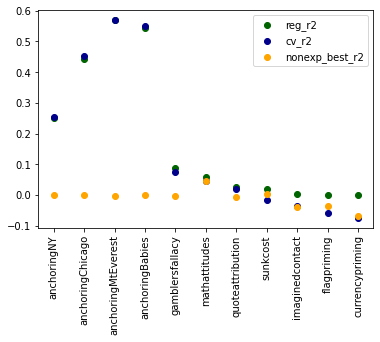

In [35]:
plt.scatter(x=summary_reg['effect'], y=summary_reg['reg_r2'], label='reg_r2', color='darkgreen')
plt.scatter(x=summary_reg['effect'], y=summary_reg['cv_mean_r2'], label='cv_r2', color='darkblue')
plt.scatter(x=summary_reg['effect'], y=summary_reg['random_cv_mean_r2'], label='nonexp_best_r2', color='orange')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.show()

The following plot compares percent correct classifications for classification problems in the standard regression, CV-LogReg and LogReg with randomly-selected variables.

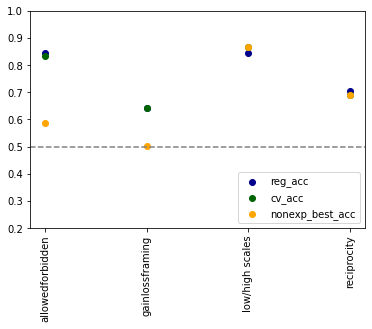

In [36]:
plt.axhline(y=.5, color='grey', linestyle='--')
plt.scatter(x=summary_class['effect'], y=summary_class['reg_perc_acc'], color='darkblue', label='reg_acc')
plt.scatter(x=summary_class['effect'], y=summary_class['cv_mean_acc'], color='darkgreen', label='cv_acc')
plt.scatter(x=summary_class['effect'], y=summary_class['random_cv_mean_acc'], color='orange', label='nonexp_best_acc')
plt.legend(loc='lower right')
plt.ylim(.2,1.)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.show()

## 10. Sunk cost effect
Dive into out-of-sample vs. in-sample performance as a function of sample size <a class="anchor" id="samplesize"></a>
We progressively decrease sample size until we reach a regression p-value slightly below .05, and inflated in-sample estimates which could lead to misinterpret the results. <br>

In [181]:
sizes = [int(s) for s in np.linspace(start=20, stop=1000)]
cv_mean_r2, cv_mean_r2_train, ols_pvals = [], [], []
kfolds = KFold(10)

for sz in sizes:

    subdf = df_stats.iloc[:sz, :][['sunkDV', 'sunkgroup', 'sample']].dropna()
    X = subdf[['sunkgroup']].values
    y = subdf['sunkDV'].values
    # OLS
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    m = est.fit()
    # CV
    cv_scores = cross_validate(est_lr, X=X, y=y, cv=kfolds,
                               return_train_score=True, scoring='r2')
    # Store results
    mean_r2 = cv_scores['test_score'].mean()
    mean_r2_train = cv_scores['train_score'].mean()
    ols_pvals.append(m.pvalues[1])
    cv_mean_r2.append(mean_r2)
    cv_mean_r2_train.append(mean_r2_train)

In [183]:
df = pd.DataFrame([sizes, cv_mean_r2, cv_mean_r2_train, ols_pvals]).T.head(n=50)
df.columns = ['size', 'test_r2', 'train_r2', 'ols_pval']

In [184]:
display(df)

,size,test_r2,train_r2,ols_pval
0,20.00000,-6.86700,0.10230,0.17208
1,40.00000,-0.53651,0.08217,0.07415
2,60.00000,-0.26398,0.06551,0.04993
3,80.00000,-0.17609,0.07931,0.01143
4,100.00000,-0.20111,0.05234,0.02267
5,120.00000,-0.14735,0.03673,0.03669
6,140.00000,-0.20401,0.02929,0.04558
7,160.00000,-0.09246,0.02824,0.03516
8,180.00000,-0.18420,0.03272,0.01570
9,200.00000,-0.10141,0.03130,0.01257


## 11. Effect variability across sites <a class="anchor" id="sites"></a>

Compute means by condition for each site

In [113]:
sites = list(df['sample'].unique())
means_1, means_2 = [], []
for idx, dv in enumerate(dvs):
    for site in sites:
        cond_1 = df[dv][(df[grps[idx]] == levels[idx][0]) & (df['sample'] == site)]
        cond_2 = df[dv][(df[grps[idx]] == levels[idx][1]) & (df['sample'] == site)]
        m1 = cond_1.dropna().mean()
        m2 = cond_2.dropna().mean()
        means_1.append(m1)
        means_2.append(m2)

Process data so to have, for all effects, a group coded as "low group" (the group with lower overall mean) and a group coded as "high" (the group wiht higher overall mean).

In [114]:
mean_by_site = pd.DataFrame(list(zip(list(np.repeat(effect_names, len(sites))), sites * len(dvs), means_1, means_2)), 
                            columns=['effect', 'site', 'mean_group1', 'mean_group2'])
mean_by_site['mean_low'] = np.nan
mean_by_site['mean_high'] = np.nan
for idx, row in mean_by_site.iterrows():
    if mean_by_site[mean_by_site['effect'] == row['effect']]['mean_group1'].mean() > mean_by_site[mean_by_site['effect'] == row['effect']]['mean_group2'].mean():
        mean_by_site.at[idx, 'mean_low'] = row['mean_group2']
        mean_by_site.at[idx, 'mean_high'] = row['mean_group1']
    else:
        mean_by_site.at[idx, 'mean_low'] = row['mean_group1']
        mean_by_site.at[idx, 'mean_high'] = row['mean_group2']
mean_by_site = mean_by_site[['effect', 'site', 'mean_low', 'mean_high']]

Plot mean values for the DV by group for all effects (facets) and all sites (y-axis).

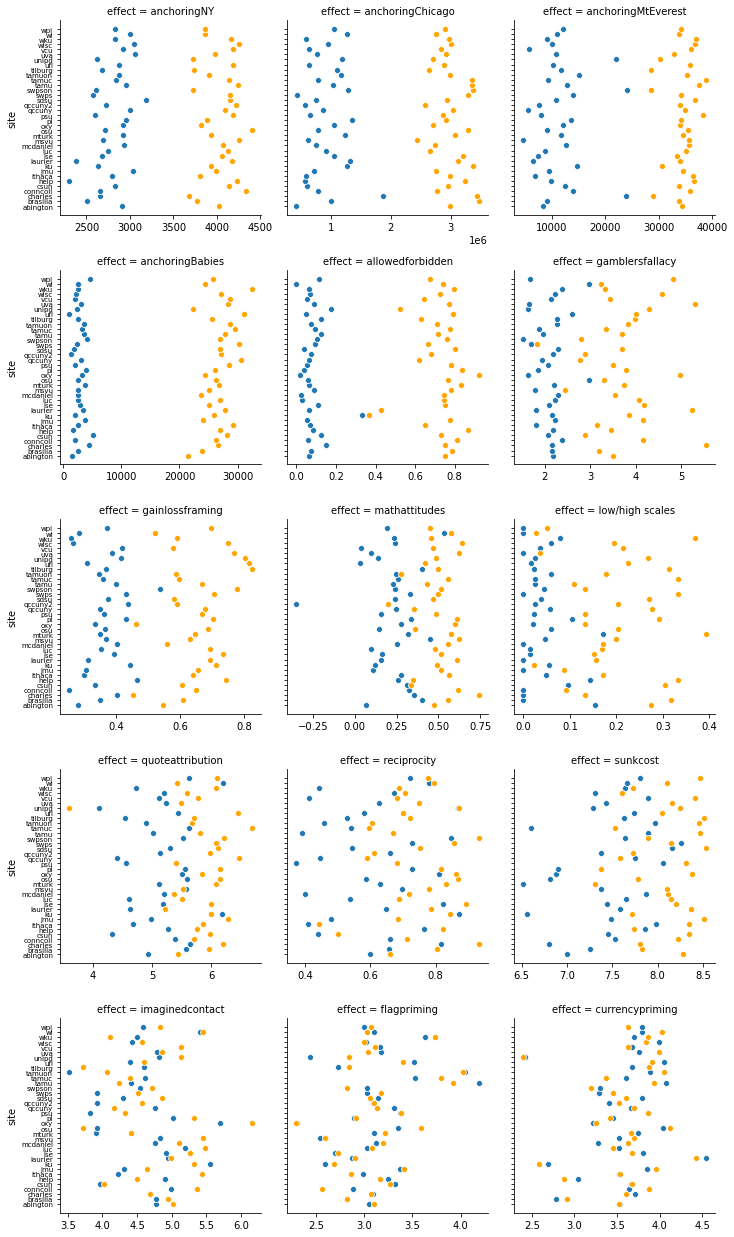

In [115]:
g = sns.FacetGrid(mean_by_site, col='effect', col_wrap=3, sharex=False, height=3.5)
g = g.map(sns.scatterplot, 'mean_low', 'site')
g = g.map(sns.scatterplot, 'mean_high', 'site', color='orange').set_axis_labels('', 'site').set_yticklabels(size=7)
plt.show()

While for some effects means are consistent across sites, for many effects means for each group and differences vary widely. Models estimated on subsets of sites may not yield good predictions on novel data from different sites. Traditional goodness-of-fit or significance metrics may hide the underlying complexity of the data, not capturing an adequate picture of the actual generalization capabilities and predictive utility of a model.